## Query processing flowchart

![Query Processing Flowchart.png](<attachment:Query Processing Flowchart.png>)
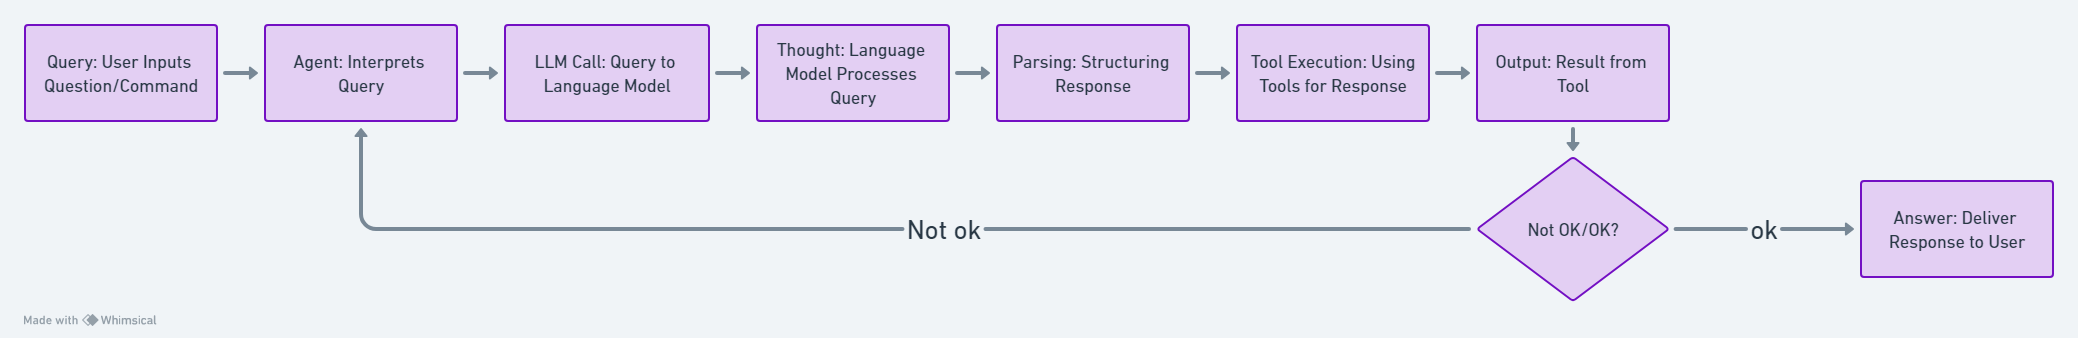

In [17]:
from typing import Union, List
from dotenv import load_dotenv
from utilities.llms import llm_3,llm_4
from langchain.agents import tool
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.schema import AgentAction, AgentFinish
from langchain.tools import Tool
from langchain.tools.render import render_text_description
from langchain.agents.output_parsers import ReActSingleInputOutputParser
from langchain.memory import ConversationBufferWindowMemory
from langchain.agents import create_react_agent, AgentExecutor
from langchain.chains import LLMChain

import os

#load variable from .env
load_dotenv()  
openai_api_key = os.getenv('OPENAI_API_KEY')

In [58]:
#function 1
def find_dog_breed(text:str) -> str:
    # Define the prompt template
    prompt_template = PromptTemplate(
        template="""
        You are a dog expert. You find its breeds from user definition of the dog.
        
        ChatHistory:{chat_history}
        Question:{input}
        """,
        input_variables={"chat_history", "input"}
    )

    # Define the memory for conversation history
    memory = ConversationBufferWindowMemory(memory_key="chat_history", k=5, return_messages=True)

    # Define the chain to process the input
    animal_chain = LLMChain(llm=llm_4, prompt=prompt_template, memory=memory, verbose=True)

    # Define input variables for the invoke method
    input_variables = {"input": f"{text}"}

    # Invoke the chain with the correct input
    res = animal_chain.invoke(input_variables)
    res = res['text']
    return (str(res)).replace("\n"," ")

#function 2
def get_text_length(text: str) -> int:
    return(f"The number of text is {len(text)}")

#function 3
def write_haiku(topic:str)->str:
    return (ChatOpenAI().predict(text=f"Write a haiku about {topic}")).replace("\n",'')
tools = [
    Tool.from_function(
        name="Count text",
        description="useful when you want to count particular word or sentences",
        func=get_text_length,
        return_direct=True
    ),
    Tool.from_function(
        name="Get haiku",
        description="useful when user ask to creat a haiku from thr topic they define",
        func=write_haiku,
        return_direct=True
    ),
    Tool.from_function(
        name='Get dog breed',
        description="useful when it's neccessary to find dog breed from user description about the dog",
        func=find_dog_breed,
        return_direct=True
    )
]

memory = ConversationBufferWindowMemory(
    memory_key="chat_history",
    k=5,
    return_messages=True,
)

agent_prompt = PromptTemplate.from_template(
    """
        You are a lawyer who is specilized in answering ansewer regard to law and regulation decision question.
        Be as helpful as possible and return as much information as possible.
        Do not answer any questions that do not relate to Law,agreement and damac.
        
        Do not answer any questions using your pre-trained knowledge, only use the information provided in the context.

        TOOLS:
        ------

        You have access to the following tools:

        {tools}

        To use a tool, please use the following format:

        ```
        Thought: Do I need to use a tool? Yes
        Action: the action to take, should be one of [{tool_names}]
        Action Input: the input to the action
        Observation: the result of the action
        ```
        When you have a response to say to the Human, or if you do not need to use a tool, you MUST use the format:

        ```
        Thought: Do I need to use a tool? No
        Final Answer: [your response here]
        ```

        Begin!

        Previous conversation history:
        {chat_history}

        New input: {input}
        {agent_scratchpad}
        
        """)

agent = create_react_agent(llm_4, 
                           tools, 
                           agent_prompt)

agent_executor = AgentExecutor(agent=agent, 
                               tools=tools, 
                               memory=memory, 
                               verbose=True, 
                               handle_parsing_errors=True)

while True:
    question = input("> ")
    if question == 'exit':
        print("thanks for using me as a tool")
        break
    else:
        response = agent_executor.invoke({"input": question})
        print(response['output'])



> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? Yes
Action: Get dog breed
Action Input: one of the smallest dog breeds in the world, known for its distinctive, petite size, large expressive eyes, and erect ears that add to its alert and lively expression. Originating in Mexico, the breed is named after the Mexican state

> Entering new LLMChain chain...
Prompt after formatting:

        You are a dog expert. You find its breeds from user definition of the dog.
        
        ChatHistory:[]
        Question:one of the smallest dog breeds in the world, known for its distinctive, petite size, large expressive eyes, and erect ears that add to its alert and lively expression. Originating in Mexico, the breed is named after the Mexican state
        

> Finished chain.
Based on your description, the dog breed you're referring to is the Chihuahua. Chihuahuas are indeed one of the smallest dog breeds, and they are known for their large eyes and erect ears which 

In [31]:
@tool
def get_text_length(text: str) -> int:
    """Returns the length of a text by characters"""
    print(f"get_text_length enter with {text=}")
    return len(text)

@tool
def write_haiku(topic:str)->str:
    """Writes a haiku about a given topic."""
    print(f"write_haiku enter with {topic=}")
    return ChatOpenAI().predict(text=f"Write a haiku about {topic}")

def find_tool_by_name(tools: List[Tool], tool_name: str) -> Tool:
    for tool in tools:
        if tool.name == tool_name:
            return tool
    raise ValueError(f"Tool wtih name {tool_name} not found")

Question = "What is the lenght of the word 'DOG' and its haiku"
tools = [get_text_length, write_haiku]

template = """
Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
"""

prompt = PromptTemplate.from_template(template=template).partial(
    tools=render_text_description(tools),
    tool_names=", ".join([t.name for t in tools]),
)

llm = ChatOpenAI(
    temperature=0, 
    stop=["\nObservation"], 
    model = "gpt-4",
    api_key=openai_api_key,
)
agent = (
    {
        "input": lambda x: x["input"],
    }
    | prompt
    | llm
    | ReActSingleInputOutputParser()
)


agent_step: Union[AgentAction, AgentFinish] = agent.invoke(
            {"input": Question}
        )

if isinstance(agent_step, AgentAction):
            tool_name = agent_step.tool
            tool_to_use = find_tool_by_name(tools, tool_name)
            tool_input = agent_step.tool_input

result = tool_to_use.func((str(tool_input)))

print(result)

WARNING! stop is not default parameter.
                    stop was transferred to model_kwargs.
                    Please confirm that stop is what you intended.


get_text_length enter with text="'DOG'"
5
